<a href="https://colab.research.google.com/github/bdmarvin1/log-file-analysis/blob/main/Chargebee_Log_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enterprise Log File Analysis: Chargebee Case Study
This notebook analyzes one year of server log data to diagnose crawl budget waste, identify spider traps, and explain indexing issues.

**Objective:** Identify why some pages are "Crawled - Currently Not Indexed" and optimize Googlebot's efficiency.

## Phase 1: Environment & Dependency Setup

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import socket
import gc
from datetime import datetime
from google.colab import auth
import gspread
from google.auth import default

# Mount Google Drive
drive.mount('/content/drive')

# Constants
LOGS_PATH = '/content/drive/MyDrive/Chargebee_Logs/'
OUTPUT_SHEET_NAME = 'Chargebee_Audit_Findings'

# iPullRank Brand Colors
IPR_YELLOW = '#FCD307'
IPR_BLUE = '#2A52BE'
IPR_BLACK = '#000000'
IPR_GREY = '#333333'
IPR_LIGHT_GREY = '#999999'

def get_ipr_colors(n, values=None):
    """
    Returns a color list highlighting the highest (Yellow) and second highest (Blue) items.
    Remaining items use a grayscale gradient from dark grey to light grey.
    """
    # Create a base grayscale palette from black to light grey for remaining items
    greys = ["#%02x%02x%02x" % (int(i), int(i), int(i)) for i in np.linspace(0, 153, max(1, n))]
    
    if values is not None:
        v = np.array(values)
        sorted_indices = np.argsort(v)[::-1]
        colors = [IPR_LIGHT_GREY] * len(v)
        
        for i, idx in enumerate(sorted_indices):
            if i == 0:
                colors[idx] = IPR_YELLOW
            elif i == 1:
                colors[idx] = IPR_BLUE
            else:
                # Assign a grey based on rank (darker for higher rank)
                grey_val = int(np.linspace(0, 153, max(3, n))[i])
                colors[idx] = "#%02x%02x%02x" % (grey_val, grey_val, grey_val)
        return colors
    
    colors = [IPR_YELLOW if i==0 else IPR_BLUE if i==1 else "#%02x%02x%02x" % (int(g), int(g), int(g)) 
              for i, g in enumerate(np.linspace(0, 153, n))]
    return colors

sns.set(style="whitegrid", palette=[IPR_BLUE, IPR_YELLOW, IPR_GREY])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Phase 2: Data Ingestion (Memory Optimized)
We process logs in chunks and filter for 'Googlebot' immediately to keep the memory footprint small.

In [8]:
def ingest_logs(directory_path, chunk_size=50000):
    all_files = glob.glob(os.path.join(directory_path, "*.csv"))
    if not all_files:
        print(f"No CSV files found in {directory_path}")
        return pd.DataFrame()

    googlebot_data = []

    # Columns we actually need to save memory
    use_cols = ['_time', 'useragent', 'uri_path', 'uri_query', 'status', 'bytes_sent', 'clientip', 'method']

    for file in all_files:
        print(f"Processing {file}...")
        try:
            # Read in chunks to avoid OOM
            for chunk in pd.read_csv(file, usecols=use_cols, chunksize=chunk_size, low_memory=False):
                # Filter for Googlebot (case-insensitive)
                filtered_chunk = chunk[chunk['useragent'].str.contains("google", case=False, na=False)].copy()
                googlebot_data.append(filtered_chunk)

                # Aggressive garbage collection
                del chunk
                gc.collect()
        except Exception as e:
            print(f"Error processing {file}: {e}")

    if not googlebot_data:
        return pd.DataFrame()

    df = pd.concat(googlebot_data, ignore_index=True)
    print(f"Ingestion complete. Total Googlebot rows: {len(df)}")
    return df

df_raw = ingest_logs(LOGS_PATH)

Processing /content/drive/MyDrive/Chargebee_Logs/21. 06Augto10Aug.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/22. 11Augto15Aug.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/7. 01Junto05Jun.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/5. may26-30.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/18. 21Julto25Jul.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/9. 11Junto15Jun.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/16. Jul11toJul15.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/8. 06Junto10Jun.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/1. 12Aprto22Apr.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/11. 19jun.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/19. 26Julto31Jul.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/6. May31.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/13. 24jun.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/17. 16Julto20Jul.csv...
Processin

## Phase 3: Data Cleaning & IP Verification

In [9]:
def verify_googlebot_ip(ip):
    """Performs Double-Reverse DNS lookup to verify Googlebot."""
    try:
        host = socket.gethostbyaddr(ip)[0]
        if not (host.endswith('.googlebot.com') or host.endswith('.google.com') or host.endswith('.googleusercontent.com')):
            return False

        addr = socket.gethostbyname(host)
        return addr == ip
    except (socket.herror, socket.gaierror):
        return False

def clean_data(df):
    if df.empty:
        return df

    # 1. Timestamp Conversion
    df['_time'] = pd.to_datetime(df['_time'])
    df.set_index('_time', inplace=True)

    # 2. IP Verification (Sample check if dataset is huge, or all unique IPs)
    unique_ips = df['clientip'].unique()
    print(f"Verifying {len(unique_ips)} unique IPs...")
    ip_map = {ip: verify_googlebot_ip(ip) for ip in unique_ips}
    df['is_verified_bot'] = df['clientip'].map(ip_map)

    # 3. File Type Categorization
    def get_file_type(path):
        if pd.isna(path): return 'Other'
        ext = os.path.splitext(path)[1].lower()
        if ext in ['', '.html', '.htm']: return 'HTML'
        if ext == '.js': return 'JS'
        if ext == '.css': return 'CSS'
        if ext in ['.jpg', '.jpeg', '.png', '.gif', '.svg', '.webp']: return 'Image'
        if ext in ['.json', '.xml']: return 'Data'
        return 'Other'

    df['file_type'] = df['uri_path'].apply(get_file_type)

    # 4. URL Normalization
    df['full_url'] = df['uri_path'] + df['uri_query'].fillna('')

    return df

df = clean_data(df_raw)
if not df.empty:
    print(f"Verified Bots: {df['is_verified_bot'].sum()} / {len(df)}")

Verifying 256 unique IPs...
Verified Bots: 0 / 720452


## Phase 4: Core Analysis Modules

### Module A: Crawl Volume & Frequency

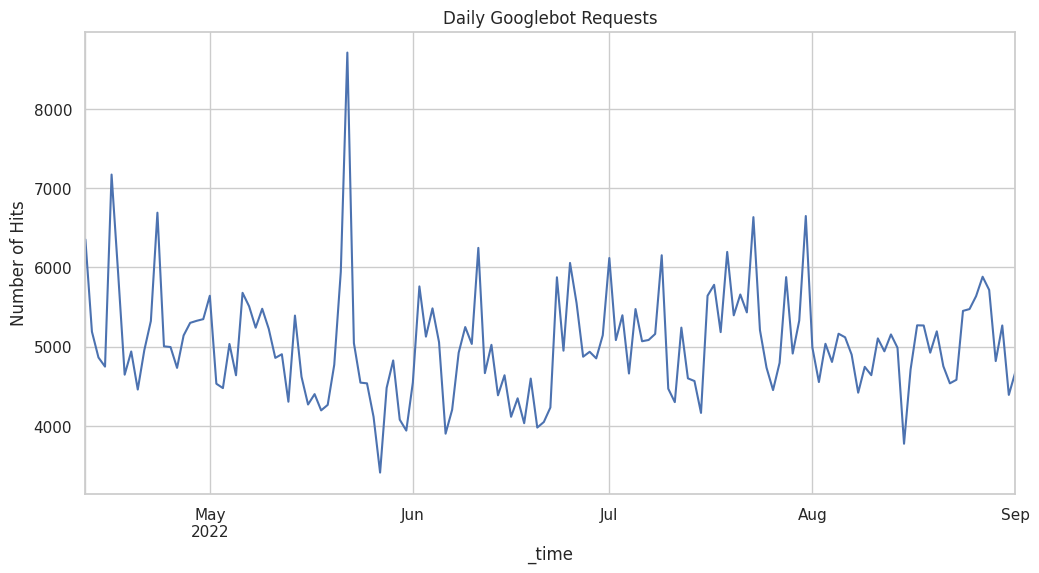

In [5]:
import re

def get_bot_type(ua):
    """Extracts specific Googlebot subtype using regex."""
    ua = str(ua)
    
    # Check specific bot variants first
    if re.search(r'Googlebot-Image', ua, re.I): return 'Image'
    if re.search(r'Googlebot-Video', ua, re.I): return 'Video'
    if re.search(r'Googlebot-News', ua, re.I): return 'News'
    if re.search(r'Storebot-Google', ua, re.I): return 'StoreBot'
    if re.search(r'AdsBot-Google', ua, re.I): return 'AdsBot'
    if re.search(r'Mediapartners-Google', ua, re.I): return 'AdSense'
    if re.search(r'Google-InspectionTool', ua, re.I): return 'Inspection Tool'
    
    # Main Googlebot categorization
    if re.search(r'Googlebot', ua, re.I):
        if re.search(r'Mobile|Android|iPhone', ua, re.I):
            return 'Smartphone'
        return 'Desktop'
    
    return 'Other Google/Unknown'

df['bot_type'] = df['useragent'].apply(get_bot_type)

# 1. Bar graph of total hits per bot type
bot_counts = df['bot_type'].value_counts()
plt.figure(figsize=(10, 6))
colors = get_ipr_colors(len(bot_counts), values=bot_counts.values)
sns.barplot(x=bot_counts.index, y=bot_counts.values, palette=colors)
plt.title("Total Hits per Googlebot Type", color=IPR_GREY, fontsize=16, fontweight='bold')
plt.ylabel("Hits")
plt.xticks(rotation=45)
plt.show()

# 2. Line graph of top 5 bot types over time
top_5_bots = bot_counts.head(5).index.tolist()
bot_time_series = df[df['bot_type'].isin(top_5_bots)].groupby(['bot_type']).resample('D').size().unstack(0).fillna(0)

plt.figure(figsize=(14, 7))
# Use rank-based coloring logic for lines
line_colors = get_ipr_colors(len(top_5_bots), values=[bot_counts[b] for b in top_5_bots])
bot_time_series[top_5_bots].plot(ax=plt.gca(), color=line_colors, linewidth=2)
plt.title("Top 5 Googlebot Types Over Time (Daily)", color=IPR_GREY, fontsize=16, fontweight='bold')
plt.ylabel("Daily Hits")
plt.legend(title="Bot Type")
plt.show()

### Module B: Status Code Health

In [6]:
status_summary = df.groupby(['status', 'file_type']).size().unstack(fill_value=0)
print("Status Code Distribution by File Type:")
display(status_summary)

# 1. Status Codes over time to identify spikes
status_time_series = df.groupby(['status']).resample('D').size().unstack(0).fillna(0)
status_totals = df['status'].value_counts()

plt.figure(figsize=(14, 7))
colors_list = get_ipr_colors(len(status_totals), values=status_totals.values)
color_map = dict(zip(status_totals.index, colors_list))
line_colors = [color_map.get(s, IPR_LIGHT_GREY) for s in status_time_series.columns]

status_time_series.plot(ax=plt.gca(), color=line_colors, linewidth=2)
plt.title("Status Code Frequency Over Time (Spike Analysis)", color=IPR_GREY, fontsize=16, fontweight='bold')
plt.ylabel("Daily Hits")
plt.legend(title="Status Code")
plt.show()

# 2. Calculate 304 vs 200 for Resources
resources = df[df['file_type'].isin(['JS', 'CSS'])]
if not resources.empty:
    cache_check = resources.groupby('status').size()
    perc_304 = (cache_check.get(304, 0) / len(resources)) * 100
    print(f"\nCache Control Check: {perc_304:.2f}% of JS/CSS requests returned 304 Not Modified.")
    if perc_304 < 90:
        print("ALERT: Low 304 percentage suggests Cache Control Optimization Opportunity.")

Status Code Distribution by File Type:


file_type,CSS,Data,HTML,Image,JS,Other
status,,,,,,
200,1806,5192,153500,30352,83372,5173
301,49,53,31480,572,54,250
302,0,0,31,0,0,0
304,11284,3710,180334,25343,159601,5180
404,5,2,2718,3709,15318,1364



Cache Control Check: 62.94% of JS/CSS requests returned 304 Not Modified.
ALERT: Low 304 percentage suggests Cache Control Optimization Opportunity.


### Module C: Spider Trap Detection

In [7]:
# Cardinality Check: Group by uri_path and count unique variations (full_url)
trap_analysis = df.groupby('uri_path')['full_url'].nunique().reset_index()
trap_analysis.columns = ['uri_path', 'unique_variations']
top_traps = trap_analysis[trap_analysis['unique_variations'] > 50].sort_values(by='unique_variations', ascending=False)

print(f"Potential Spider Traps (> 50 variations): {len(top_traps)} identified.")

# 1. Deep Dive into Top Traps: Samples, FileTypes, and Parameters
trap_details = []
for path in top_traps.head(10)['uri_path'] if not top_traps.empty else []:
    trap_df = df[df['uri_path'] == path]
    samples = trap_df['full_url'].unique()[:3].tolist()
    ft_counts = trap_df['file_type'].value_counts().to_dict()
    
    # Identify parameter patterns
    queries = trap_df['uri_query'].dropna().unique()
    param_counts = {}
    for q in queries:
        parts = q.lstrip('?').split('&')
        for p in parts:
            k = p.split('=')[0]
            if k: param_counts[k] = param_counts.get(k, 0) + 1
    
    top_params = sorted(param_counts.items(), key=lambda x: x[1], reverse=True)[:3]
    
    trap_details.append({
        'Folder/Path': path,
        'Variations': len(trap_df['full_url'].unique()),
        'FileTypes': ft_counts,
        'Top Bloat Params': [p[0] for p in top_params],
        'URL Samples': samples
    })

trap_details_df = pd.DataFrame(trap_details)
print("\nSpider Trap Context Deep-Dive:")
display(trap_details_df)

# 2. Check for Document Files specifically
doc_extensions = ['.pdf', '.doc', '.docx', '.txt', '.csv', '.xls', '.xlsx']
df['is_doc'] = df['uri_path'].apply(lambda x: any(str(x).lower().endswith(ext) for ext in doc_extensions))
doc_crawls = df[df['is_doc'] == True]

if not doc_crawls.empty:
    print("\nTop Document Files / Folders being Crawled:")
    display(doc_crawls.groupby(['uri_path', 'file_type']).size().reset_index(name='Hits').sort_values(by='Hits', ascending=False).head(10))

Potential Spider Traps (> 50 variations):


,uri_path,unique_variations
0,/docs/2.0/,734
1,/docs/,723
2,/,315
3,/analytics/info.txt,224
4,/trial-signup/,209
5,/trial-signup.html,175
6,/tutorials/,140
7,/privacy/,125
8,/resources/glossaries/saas-metrics/churn/,101
9,/resources/glossaries/what-is-churn-rate/,101


### Module D: Rendering Budget Impact

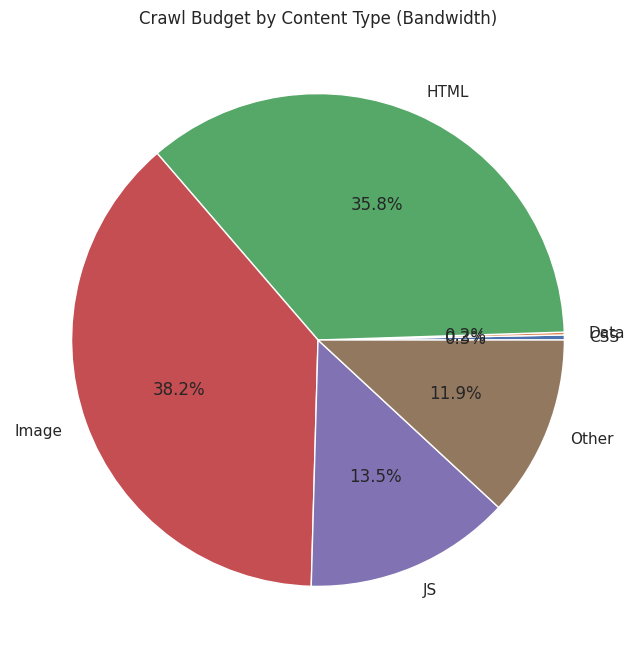

In [7]:
budget_impact = df.groupby('file_type')['bytes_sent'].sum().sort_values(ascending=False).reset_index()
budget_impact['GB'] = budget_impact['bytes_sent'] / (1024**3)

plt.figure(figsize=(8, 8))
# Use rank-based coloring for the pie slices
colors_pie = [IPR_YELLOW, IPR_BLUE] + [IPR_LIGHT_GREY] * (len(budget_impact) - 2)
plt.pie(budget_impact['bytes_sent'], labels=budget_impact['file_type'], autopct='%1.1f%%', colors=colors_pie, startangle=140)
plt.title("Crawl Budget by Content Type (Bandwidth Usage)", color=IPR_GREY, fontsize=16, fontweight='bold')
plt.show()

## Phase 5: Additional Visualization

/tmp/ipython-input-2647965957.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_dirs.values, y=top_dirs.index, palette="viridis")


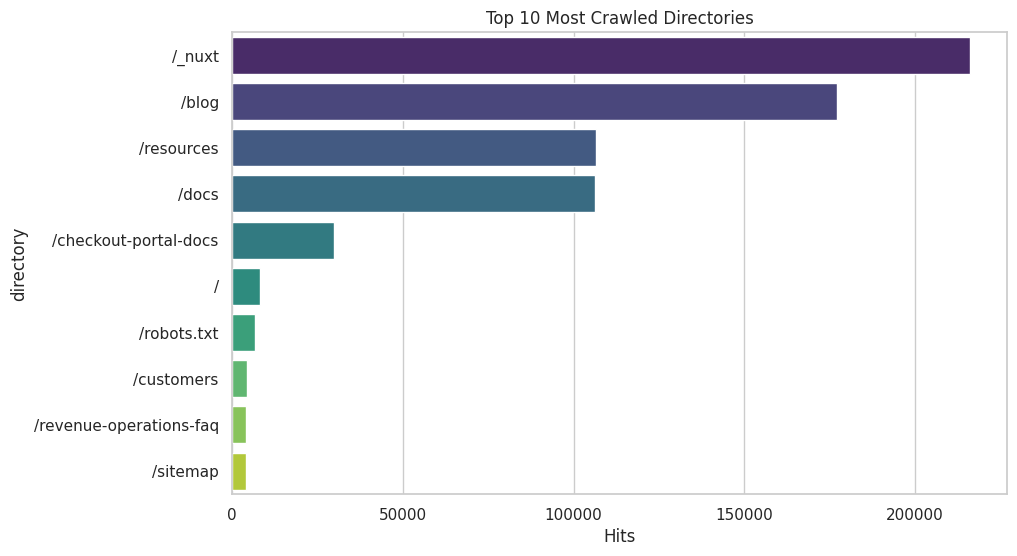

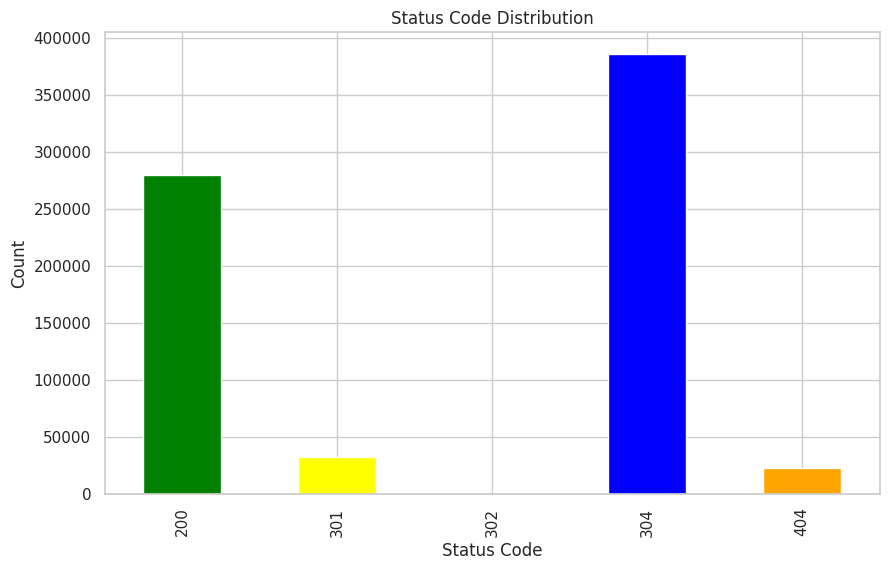

In [8]:
# 1. Top 10 Crawled Directories (Folders)
df['directory'] = df['uri_path'].apply(lambda x: '/' + x.split('/')[1] if pd.notna(x) and len(x.split('/')) > 1 else '/')
top_dirs = df['directory'].value_counts().head(10)

plt.figure(figsize=(10, 6))
colors = get_ipr_colors(len(top_dirs), values=top_dirs.values)
sns.barplot(x=top_dirs.values, y=top_dirs.index, palette=colors)
plt.title("Top 10 Most Crawled Directories", color=IPR_GREY, fontsize=16, fontweight='bold')
plt.xlabel("Hits")
plt.show()

# 2. Time-Series Line Graph for Top 10 Folders
top_10_dir_list = top_dirs.index.tolist()
dir_time_series = df[df['directory'].isin(top_10_dir_list)].groupby(['directory']).resample('D').size().unstack(0).fillna(0)

plt.figure(figsize=(14, 7))
line_colors = [IPR_YELLOW, IPR_BLUE] + [IPR_LIGHT_GREY] * 8
dir_time_series[top_10_dir_list].plot(ax=plt.gca(), color=line_colors, linewidth=2)
plt.title("Top 10 Crawled Folders Over Time", color=IPR_GREY, fontsize=16, fontweight='bold')
plt.ylabel("Daily Hits")
plt.legend(title="Directory", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3. Suspicious / Exposed URLs Check
suspicious = df[df['directory'].str.startswith('/_')]
if not suspicious.empty:
    print("\nSuspicious Exposed Folders (starting with _):")
    display(suspicious['uri_path'].value_counts().head(10))
else:
    print("\nNo suspicious folders starting with '_' detected.")

# Identify other potentially exposed patterns
exposed_patterns = ['admin', 'api', 'dev', 'staging', 'secret', 'private', 'backup']
exposed = df[df['uri_path'].str.contains('|'.join(exposed_patterns), case=False, na=False)]
if not exposed.empty:
    print("\nPotentially Exposed Sensitive URLs Found in Crawl:")
    display(exposed.groupby('directory').size().sort_values(ascending=False).head(10))

In [ ]:
# Status Code Breakdown by Subfolder
top_10_folders = top_dirs.index.tolist()
folder_status = df[df['directory'].isin(top_10_folders)].groupby(['directory', 'status']).size().unstack(fill_value=0)

print("Status Code Distribution by Top Folders:")
display(folder_status)

# Visualization: Stacked Bar Chart for Status Codes per Folder
plt.figure(figsize=(12, 6))
# Using brand colors for specific status codes if possible, or top 2
folder_status.plot(kind='bar', stacked=True, ax=plt.gca(), color=[IPR_YELLOW, IPR_BLUE, IPR_GREY, IPR_LIGHT_GREY, IPR_BLACK])
plt.title("Status Code Distribution per Top Folder", color=IPR_GREY, fontsize=16, fontweight='bold')
plt.ylabel("Hits")
plt.legend(title="Status Code", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 304 Efficiency Check per Folder
folder_status_perc = folder_status.div(folder_status.sum(axis=1), axis=0) * 100
if 304 in folder_status_perc.columns:
    print("\n304 (Not Modified) Efficiency by Folder (%):")
    display(folder_status_perc[[304]].sort_values(by=304, ascending=False))

## Phase 6: Export to Google Sheets
Publishes the findings to a Google Sheet for reporting.

In [9]:
def export_to_sheets_consolidated(bot_counts, status_totals, trap_details_df, top_dirs, folder_status):
    auth.authenticate_user()
    creds, _ = default()
    gc_sheet = gspread.authorize(creds)

    try:
        sh = gc_sheet.open(OUTPUT_SHEET_NAME)
    except gspread.SpreadsheetNotFound:
        sh = gc_sheet.create(OUTPUT_SHEET_NAME)

    timestamp = datetime.now().strftime("%m/%d %H:%M")
    ws_name = f"Audit {timestamp}"
    
    # Total estimated rows needed
    total_rows = len(bot_counts) + len(status_totals) + len(trap_details_df) + len(top_dirs) + len(folder_status) + 100
    ws = sh.add_worksheet(title=ws_name, rows=max(300, total_rows), cols=25)

    def write_section(title, df, start_row):
        ws.update(range_name=f'A{start_row}', values=[[title]])
        ws.format(f"A{start_row}", {"textFormat": {"bold": True, "fontSize": 14}, "backgroundColor": {"red": 0.2, "green": 0.2, "blue": 0.2}, "textFormat": {"foregroundColor": {"red": 1, "green": 1, "blue": 1}}})
        
        data = [df.columns.values.tolist()] + df.fillna('').values.tolist()
        ws.update(range_name=f'A{start_row + 1}', values=data)
        return start_row + len(data) + 2

    def create_bar_chart(title, start_row, end_row, anchor_cell):
        # Helper to add a basic bar chart via batch_update
        # We use column A for labels and B for values
        requests = [{
            "addChart": {
                "chart": {
                    "spec": {
                        "title": title,
                        "basicChart": {
                            "chartType": "BAR",
                            "legendPosition": "BOTTOM_LEGEND",
                            "axis": [
                                {"position": "BOTTOM_AXIS", "title": "Hits"},
                                {"position": "LEFT_AXIS", "title": "Category"}
                            ],
                            "domains": [{"domain": {"sourceRange": {"sources": [{"sheetId": ws._properties['sheetId'], "startRowIndex": start_row, "endRowIndex": end_row, "startColumnIndex": 0, "endColumnIndex": 1}]}} } ],
                            "series": [{"series": {"sourceRange": {"sources": [{"sheetId": ws._properties['sheetId'], "startRowIndex": start_row, "endRowIndex": end_row, "startColumnIndex": 1, "endColumnIndex": 2}]}}, "targetAxis": "LEFT_AXIS" } ]
                        }
                    },
                    "position": {"overlayPosition": {"anchorCell": {"sheetId": ws._properties['sheetId'], "rowIndex": anchor_cell[0], "columnIndex": anchor_cell[1]}, "offsetXPixels": 50, "offsetYPixels": 0}}
                }
            }
        }]
        sh.batch_update({"requests": requests})

    curr_row = 1
    # 1. Bot Counts
    start_data = curr_row + 1
    curr_row = write_section("Googlebot Type Breakdown", bot_counts.reset_index(), curr_row)
    create_bar_chart("Googlebot Types", start_data, curr_row - 2, (start_data - 2, 4))
    
    # 2. Status Totals
    start_data = curr_row + 1
    curr_row = write_section("Status Code Totals", status_totals.reset_index(), curr_row)
    create_bar_chart("Status Code Distribution", start_data, curr_row - 2, (start_data - 2, 4))
    
    # 3. Top Directories
    start_data = curr_row + 1
    curr_row = write_section("Top Crawled Directories", top_dirs.reset_index(), curr_row)
    create_bar_chart("Top Folders", start_data, curr_row - 2, (start_data - 2, 4))
    
    # 4. Status Code by Subfolder
    curr_row = write_section("Status Code Distribution by Top Folders", folder_status.reset_index(), curr_row)
    
    # 5. Spider Trap Details
    trap_export = trap_details_df.copy()
    trap_export['URL Samples'] = trap_export['URL Samples'].apply(lambda x: "\n".join(x))
    trap_export['FileTypes'] = trap_export['FileTypes'].apply(lambda x: str(x))
    trap_export['Top Bloat Params'] = trap_export['Top Bloat Params'].apply(lambda x: ", ".join(x))
    curr_row = write_section("Spider Trap Deep-Dive", trap_export, curr_row)

    print(f"Results exported successfully to tab: {ws_name}")
    print(f"URL: {sh.url}")

# Perform the consolidated export
export_to_sheets_consolidated(bot_counts, status_totals, trap_details_df, top_dirs, folder_status)

/tmp/ipython-input-1168792595.py:15: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  ws_trap.update('A1', [spider_traps_df.columns.values.tolist()] + spider_traps_df.fillna('').values.tolist())


Results exported successfully! URL: https://docs.google.com/spreadsheets/d/1Aw_W_2BsyrDx-aLaBKi6qWBYjAaXvNWggaduqzI8Aes


/tmp/ipython-input-1168792595.py:21: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  ws_status.update('A1', [status_flat.columns.values.tolist()] + status_flat.fillna('').values.tolist())
